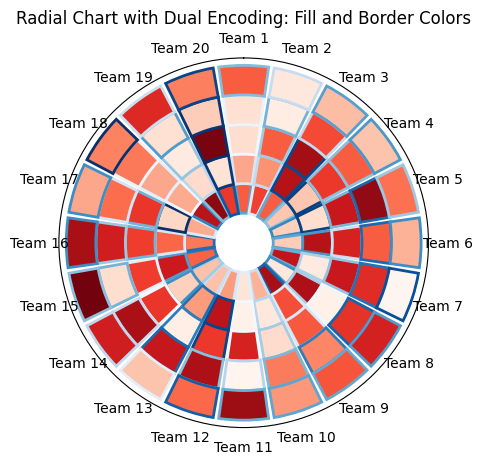

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Exemplo de dados para 5 posições e 5 times
avgs = np.random.randint(0, 91, size=(5, 20))  # Valores entre 0 e 90 para preenchimento
aux = np.random.randint(0, 51, size=(5, 20))  # Valores entre 0 e 50 para cor da borda

# Número de posições e times
num_positions, num_teams = avgs.shape

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})

width = 2 * np.pi / num_teams
inner_radius = 1
ring_width = 1

# Normalizar os valores para as escalas de cores
norm_avg = avgs / 90
norm_aux = aux / 50

# Criar os anéis do gráfico radial
for i in range(num_positions):
    for j in range(num_teams):
        theta = j * width
        fill_color = plt.cm.Reds(norm_avg[i, j])  # Cor de preenchimento
        border_color = plt.cm.Blues(norm_aux[i, j])  # Cor da borda
        ax.bar(
            theta,
            ring_width,  # Altura do anel
            width=width * 0.9,  # Largura angular
            bottom=inner_radius + ring_width * i,  # Posição do anel
            color=fill_color,
            edgecolor=border_color,
            linewidth=2,
        )

# Configurar os rótulos e o grid
ax.set_xticks(np.linspace(0, 2 * np.pi, num_teams, endpoint=False))
ax.set_xticklabels([f"Team {i+1}" for i in range(num_teams)])
ax.set_yticklabels([])
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.grid(False)

plt.title("Radial Chart with Dual Encoding: Fill and Border Colors")
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_38812\2156113784.py:61: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_team.pivot_table(


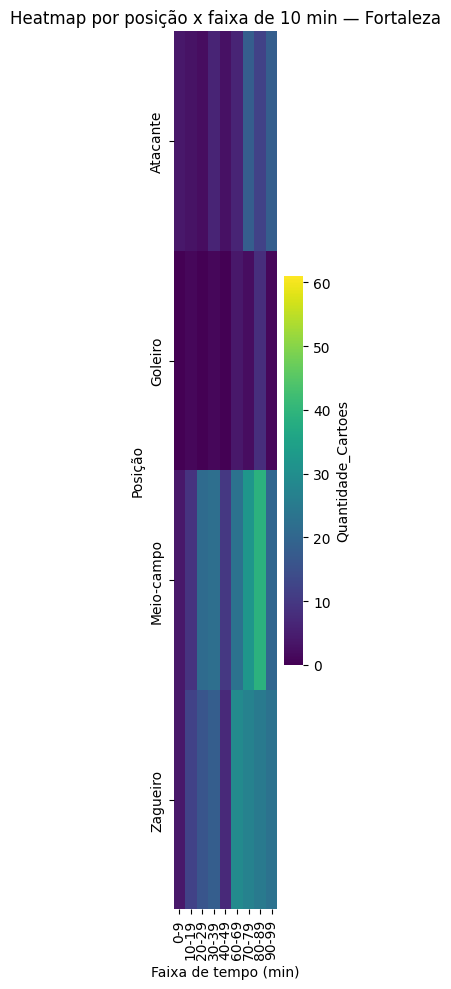

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# DataFrame usado (ajuste se o seu tiver outro nome)
df = pd.read_csv(
    "../../data/processed/analise_cartoes.csv"
)  # ou substitua por `df = seu_dataframe`

# Ajuste os nomes de colunas conforme seu dataset
minute_col = "tempo_jogo"
position_col = "posicao"
team_col = "clube"
value_col = "Quantidade_Cartoes"

# Verifica times disponíveis e ajusta selected_team se necessário
available_teams = df[team_col].dropna().unique().tolist()
selected_team = "Fortaleza"  # substitua pelo nome do time que quer analisar

if not available_teams:
    raise ValueError("Nenhum time encontrado em coluna 'clube' do DataFrame.")
if selected_team == None or selected_team not in available_teams:
    print(
        f"selected_team inválido; usando primeiro time disponível: {available_teams[0]}"
    )
    selected_team = available_teams[0]

# Garantir coluna de minuto numérica
df[minute_col] = pd.to_numeric(df[minute_col].str[0:2], errors="coerce")

# Filtrar pelo time escolhido
df_team = df[df[team_col] == selected_team].copy()
if df_team.empty:
    print(
        f"Nenhum dado para o time '{selected_team}'. Times disponíveis: {available_teams[:10]}"
    )
else:
    # Criar faixas de 10 minutos: 0-9, 10-19, ..., 90-99
    bins = np.arange(0, 101, 10)
    labels = [f"{i}-{i+9}" for i in range(0, 100, 10)]
    # remover linhas sem minuto
    df_team = df_team.dropna(subset=[minute_col])
    if df_team.empty:
        print(
            f"Dados do time '{selected_team}' não têm valores válidos em '{minute_col}'."
        )
    else:
        # clip para garantir que 100+ não quebre as faixas (se houver)
        # df_team[minute_col] = df_team[minute_col].clip(lower=0, upper=100)
        df_team["time_bin"] = pd.cut(
            df_team[minute_col],
            bins=bins,
            labels=labels,
            right=False,
            include_lowest=True,
        )

        # Pivot: posições no y e faixas de tempo no x. Agregação: soma/ média ou contagem se não houver value_col
        if value_col and value_col in df_team.columns:
            pivot = df_team.pivot_table(
                index=position_col, columns="time_bin", values=value_col, aggfunc="mean"
            ).fillna(0)
        else:
            pivot = df_team.pivot_table(
                index=position_col,
                columns="time_bin",
                values=minute_col,
                aggfunc="count",
            ).fillna(0)

        pivot = pivot.sort_index()

        # Verificação antes de plotar
        if pivot.size == 0 or pivot.shape[0] == 0 or pivot.shape[1] == 0:
            print(
                "Pivot vazio — nada a plotar. Verifique 'selected_team' e as colunas usadas."
            )
        else:
            plt.figure(figsize=(2.5, 10))
            sns.heatmap(
                pivot,
                cmap="viridis",
                annot=False,
                fmt=".0f",
                cbar_kws={"label": "Contagem" if value_col is None else value_col},
                vmin=0,  # Define o valor mínimo da escala
                vmax=61  # Define o valor máximo da escala

            )
            plt.title(f"Heatmap por posição x faixa de 10 min — {selected_team}")
            plt.xlabel("Faixa de tempo (min)")
            plt.ylabel("Posição")
            plt.tight_layout()
            plt.show()

In [21]:
pivot

time_bin,0-9,10-19,20-29,30-39,40-49,60-69,70-79,80-89,90-99
posicao,,,,,,,,,
Atacante,4.0,3.0,2.0,6.0,2.666667,6.0,18.0,12.0,18.0
Goleiro,0.0,1.0,0.0,1.0,0.000000,4.0,2.0,8.0,1.0
Meio-campo,4.0,9.0,21.0,22.0,10.000000,23.0,32.0,39.0,20.0
Zagueiro,4.0,12.0,16.0,18.0,7.000000,29.0,27.0,25.0,23.0


In [18]:
cards_df = pd.read_csv(
    "../../data/processed/analise_cartoes.csv"
)  # ou substitua por `df = seu_dataframe`
cards_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496 entries, 0 to 1495
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   posicao             1496 non-null   object
 1   tempo_jogo          1496 non-null   object
 2   clube               1496 non-null   object
 3   Quantidade_Cartoes  1496 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 46.9+ KB


In [ ]:
card_pivot = df_team.pivot_table(
                index=position_col,
                columns="time_bin",
                values=minute_col,
                aggfunc="count",
            ).fillna(0)

In [ ]:

sns.heatmap(cards_df[cards_df['clube'] == 'Fortaleza'], 
            vmin=0,  # Define o valor mínimo da escala
            vmax=61,  # Define o valor máximo da escala
            
            )

ValueError: could not convert string to float: 'Atacante'

In [19]:
cards_df[team_col].dropna().unique().tolist()

['America-MG',
 'Athletico-PR',
 'Atletico-GO',
 'Atletico-MG',
 'Avai',
 'Bahia',
 'Botafogo-RJ',
 'Bragantino',
 'CSA',
 'Ceara',
 'Chapecoense',
 'Corinthians',
 'Coritiba',
 'Criciuma',
 'Cruzeiro',
 'Cuiaba',
 'Figueirense',
 'Flamengo',
 'Fluminense',
 'Fortaleza',
 'Goias',
 'Gremio',
 'Internacional',
 'Joinville',
 'Juventude',
 'Palmeiras',
 'Parana',
 'Ponte Preta',
 'Santa Cruz',
 'Santos',
 'Sao Paulo',
 'Sport',
 'Vasco',
 'Vitoria']